In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


New features

Loaded: (3672, 70)
After cleaning: (3672, 71)
Classes: ['Adults (40-65)', 'Children (7-12)', 'Pre-school (3-6)', 'Seniors (65+)', 'Teens (13-17)', 'Young Adults (18-40)']
Original dim: 68 Expanded dim: 2346
Train: (2579, 2346) Val: (562, 2346) Test: (531, 2346)
Device: cuda
Epoch 001 | Train Loss: 1.3904 | Val Loss: 1.1392 | Train Acc: 0.5463 | Val Acc: 0.7544
  Saved best model and checkpoint
Epoch 002 | Train Loss: 1.0977 | Val Loss: 0.9593 | Train Acc: 0.6824 | Val Acc: 0.7456
Epoch 003 | Train Loss: 0.9482 | Val Loss: 0.8393 | Train Acc: 0.7243 | Val Acc: 0.7562
  Saved best model and checkpoint
Epoch 004 | Train Loss: 0.8506 | Val Loss: 0.7623 | Train Acc: 0.7297 | Val Acc: 0.7544
Epoch 005 | Train Loss: 0.7734 | Val Loss: 0.7229 | Train Acc: 0.7546 | Val Acc: 0.7687
  Saved best model and checkpoint
Epoch 006 | Train Loss: 0.6962 | Val Loss: 0.6360 | Train Acc: 0.7801 | Val Acc: 0.7989
  Saved best model and checkpoint
Epoch 007 | Train Loss: 0.6476 | Val Loss: 0.5744 | Train Acc

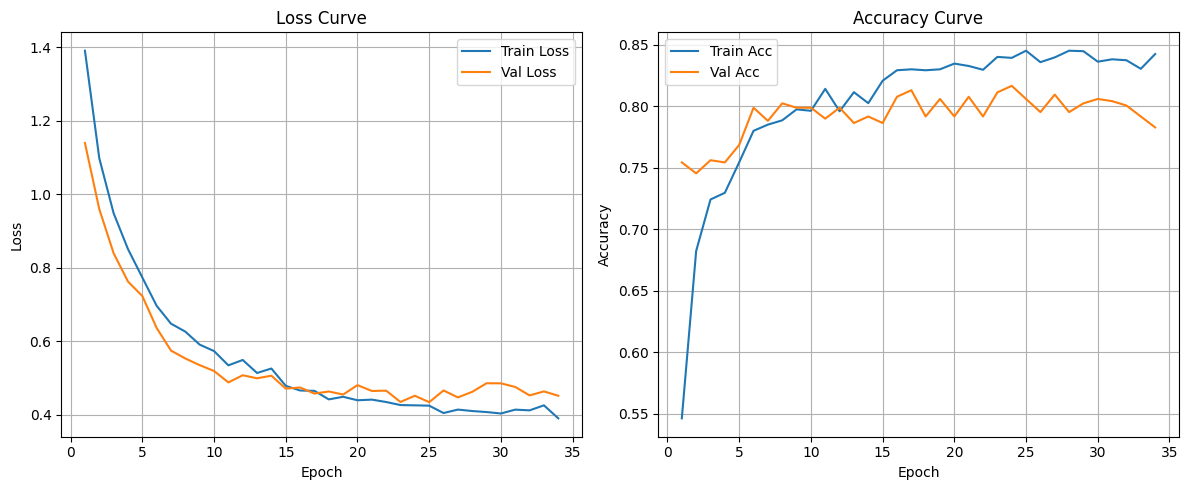

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
import matplotlib.pyplot as plt

MASTER = "/content/drive/MyDrive/DLCV_HW5/Dataset/master_features_augmented.csv"
df = pd.read_csv(MASTER)

print("Loaded:", df.shape)

def infer_split(p):
    if "/train/" in p:
        return "train"
    elif "/test/" in p:
        return "val"
    elif "/val/" in p:
        return "test"
    else:
        return "unknown"

df["split"] = df["img_path"].apply(infer_split)

non_feature_cols = ["img_path", "age_class", "split"]
feature_cols = [c for c in df.columns if c not in non_feature_cols]

feat_df = df[feature_cols].copy()

feat_df = feat_df.replace([np.inf, -np.inf], np.nan)
mask_valid = ~feat_df.isna().any(axis=1)

df = df[mask_valid].reset_index(drop=True)
feat_df = feat_df[mask_valid].reset_index(drop=True)

print("After cleaning:", df.shape)

le = LabelEncoder()
df["label"] = le.fit_transform(df["age_class"])
num_classes = len(le.classes_)
print("Classes:", list(le.classes_))

X_raw = feat_df.values   # base numeric features
y = df["label"].values
splits = df["split"].values

# Use degree=2 interactions only to avoid too huge dimension
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_poly = poly.fit_transform(X_raw)

print("Original dim:", X_raw.shape[1], "Expanded dim:", X_poly.shape[1])

X = X_poly  # use expanded features

X_train = X[splits == "train"]
y_train = y[splits == "train"]

X_val = X[splits == "val"]
y_val = y[splits == "val"]

X_test = X[splits == "test"]
y_test = y[splits == "test"]

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)

X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.long)

X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t, y_val_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

input_dim = X_train_scaled.shape[1]

class MLP(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = MLP(input_dim, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=3e-4,         # slightly lower LR
    weight_decay=1e-4  # lighter L2 regularization
)

num_epochs = 1000
patience = 10
best_val_acc = 0.0
epochs_no_improve = 0

best_model_path = "/content/drive/MyDrive/DLCV_HW5/Dataset/best_mlp_poly_features.pt"
checkpoint_path = "/content/drive/MyDrive/DLCV_HW5/Dataset/best_mlp_poly_features_checkpoint.pt"

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(1, num_epochs + 1):
    # Train
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            logits = model(xb)
            loss = criterion(logits, yb)

            val_running_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            val_correct += (preds == yb).sum().item()
            val_total += yb.size(0)

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(
        f"Epoch {epoch:03d} | "
        f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
        f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}"
    )

    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0

        torch.save(model.state_dict(), best_model_path)

        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_val_acc": best_val_acc,
            },
            checkpoint_path,
        )

        print("  Saved best model and checkpoint")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping")
            break

print("Best Val Acc:", best_val_acc)

best_model = MLP(input_dim, num_classes).to(device)
best_model.load_state_dict(torch.load(best_model_path, map_location=device))
best_model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        logits = best_model(xb)
        preds = logits.argmax(dim=1)
        test_correct += (preds == yb).sum().item()
        test_total += yb.size(0)

test_acc = test_correct / test_total
print("Test Accuracy:", test_acc)

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label="Train Acc")
plt.plot(epochs_range, val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Device: cuda
[train] Found 2579 images
[val] Found 531 images
[test] Found 562 images
Num classes: 6


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 01 | Train loss=1.5117 acc=0.3955 | Val loss=1.2964 acc=0.5122 | patience 0/5
Epoch 02 | Train loss=1.1724 acc=0.6076 | Val loss=1.1161 acc=0.6196 | patience 0/5
Epoch 03 | Train loss=1.0231 acc=0.6518 | Val loss=1.0162 acc=0.6685 | patience 0/5
Epoch 04 | Train loss=0.9407 acc=0.6751 | Val loss=0.9566 acc=0.6855 | patience 0/5
Epoch 05 | Train loss=0.8881 acc=0.6809 | Val loss=0.9068 acc=0.7043 | patience 0/5
Epoch 06 | Train loss=0.8395 acc=0.6968 | Val loss=0.8673 acc=0.7081 | patience 0/5
Epoch 07 | Train loss=0.7948 acc=0.7119 | Val loss=0.8480 acc=0.7062 | patience 1/5
Epoch 08 | Train loss=0.7651 acc=0.7166 | Val loss=0.8301 acc=0.7119 | patience 0/5
Epoch 09 | Train loss=0.7383 acc=0.7263 | Val loss=0.8144 acc=0.7250 | patience 0/5
Epoch 10 | Train loss=0.7111 acc=0.7433 | Val loss=0.7992 acc=0.7288 | patience 0/5
Epoch 11 | Train loss=0.6991 acc=0.7499 | Val loss=0.7817 acc=0.7382 | patience 0/5
Epoch 12 | Train loss=0.6753 acc=0.7511 | Val loss=0.7627 acc=0.7363 | patie

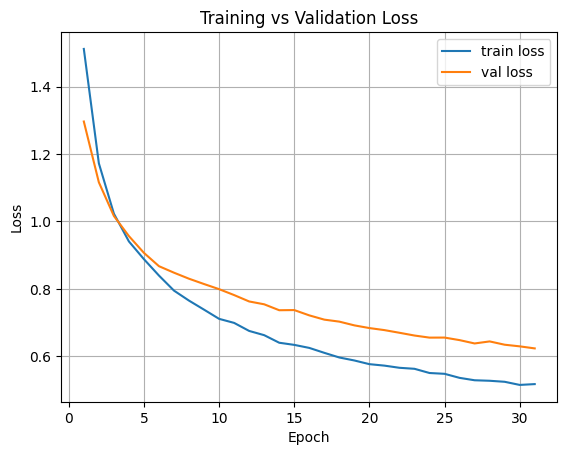

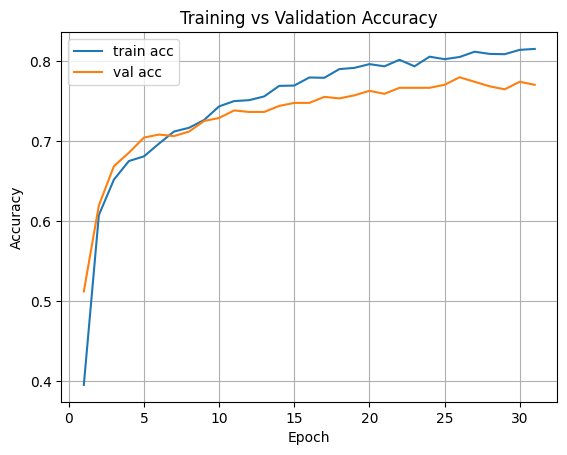


Test | loss=0.7088, acc=0.7313

Classification report:
                      precision    recall  f1-score   support

      Adults (40-65)       0.78      0.83      0.80       156
     Children (7-12)       0.79      0.47      0.59       104
    Pre-school (3-6)       0.70      0.86      0.77       136
       Seniors (65+)       0.80      0.60      0.69        20
       Teens (13-17)       0.82      0.80      0.81        69
Young Adults (18-40)       0.56      0.62      0.59        77

            accuracy                           0.73       562
           macro avg       0.74      0.70      0.71       562
        weighted avg       0.74      0.73      0.73       562

Confusion matrix:
[[130   0   0   1   1  24]
 [  4  49  45   1   0   5]
 [  6  12 117   1   0   0]
 [  4   0   4  12   0   0]
 [  6   0   0   0  55   8]
 [ 17   1   0   0  11  48]]


In [ ]:
import os, random
from pathlib import Path
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Install / import transformers (ViTModel)
try:
    from transformers import ViTModel
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "transformers"])
    from transformers import ViTModel


BASE = Path("/content/drive/MyDrive/DLCV_HW5/Dataset")

AGE_CLASSES = [
    "Adults (40-65)",
    "Children (7-12)",
    "Pre-school (3-6)",
    "Seniors (65+)",
    "Teens (13-17)",
    "Young Adults (18-40)",
]
num_classes = len(AGE_CLASSES)
label_map = {cls: i for i, cls in enumerate(AGE_CLASSES)}

IMG_SIZE = 224
batch_size = 32
EPOCHS = 50
PATIENCE = 5
LEARNING_RATE = 1e-4

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


class AgeHandwritingDataset(Dataset):
    def __init__(self, base_dir, split, transform=None):
        """
        base_dir: dataset root
        split: "train", "val", or "test"
        """
        self.base_dir = Path(base_dir)
        self.split = split
        self.transform = transform

        self.class_names = AGE_CLASSES
        self.label_map = {cls_name: i for i, cls_name in enumerate(self.class_names)}

        self.samples = []  # list of (img_path, label_idx)

        exts = ("*.png", "*.jpg", "*.jpeg", "*.bmp", "*.JPG", "*.JPEG", "*.PNG")
        for cls_name in self.class_names:
            class_dir = self.base_dir / cls_name / split
            if not class_dir.exists():
                print(f"[Warning] Folder not found: {class_dir}")
                continue
            for ext in exts:
                for img_path in class_dir.glob(ext):
                    self.samples.append((img_path, self.label_map[cls_name]))

        print(f"[{split}] Found {len(self.samples)} images")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception:
            # skip broken image
            return self.__getitem__((idx + 1) % len(self.samples))

        if self.transform is not None:
            img = self.transform(img)

        # CrossEntropyLoss expects class indices (long)
        label = torch.tensor(label, dtype=torch.long)
        return img, label


train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
])

val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
])

train_ds = AgeHandwritingDataset(BASE, "train", transform=train_tf)
val_ds   = AgeHandwritingDataset(BASE, "val",   transform=val_tf)
test_ds  = AgeHandwritingDataset(BASE, "test",  transform=val_tf)

train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True,
    num_workers=2, pin_memory=(DEVICE.type == 'cuda')
)
val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False,
    num_workers=2, pin_memory=(DEVICE.type == 'cuda')
)
test_loader = DataLoader(
    test_ds, batch_size=batch_size, shuffle=False,
    num_workers=2, pin_memory=(DEVICE.type == 'cuda')
)

print(f"Num classes: {num_classes}")


class ViTAgeClassifier(nn.Module):
    def __init__(self, name="google/vit-base-patch16-224", num_classes=6):
        super().__init__()

        self.vit = ViTModel.from_pretrained(name)
        hidden = self.vit.config.hidden_size

        self.fc = nn.Linear(hidden, num_classes)

        for p in self.vit.parameters():
            p.requires_grad = False
        for p in self.fc.parameters():
            p.requires_grad = True

    def forward(self, x):
        # x: (B, 3, H, W)
        out = self.vit(pixel_values=x)   # returns BaseModelOutputWithPooling
        cls = out.last_hidden_state[:, 0]  # CLS token
        logits = self.fc(cls)             # (B, num_classes)
        return logits


model = ViTAgeClassifier(num_classes=num_classes).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LEARNING_RATE
)

# path to save best model
best_model_path = "/content/drive/MyDrive/DLCV_HW5/Dataset/best_vit_age_classifier.pt"


best_val_acc = -1.0
best_state = None
epochs_without_improve = 0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for ep in range(1, EPOCHS + 1):

    model.train()
    total_loss = 0.0
    total_correct = 0
    total_n = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        preds = logits.argmax(dim=1)
        total_loss += loss.item() * imgs.size(0)
        total_correct += (preds == labels).sum().item()
        total_n += labels.size(0)

    train_loss = total_loss / total_n
    train_acc = total_correct / total_n

    model.eval()
    val_loss_sum = 0.0
    val_correct = 0
    val_n = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            logits = model(imgs)
            loss = criterion(logits, labels)

            preds = logits.argmax(dim=1)
            val_loss_sum += loss.item() * imgs.size(0)
            val_correct += (preds == labels).sum().item()
            val_n += labels.size(0)

    val_loss = val_loss_sum / val_n if val_n > 0 else 0.0
    val_acc = val_correct / val_n if val_n > 0 else 0.0

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    improved = val_acc > best_val_acc
    if improved:
        best_val_acc = val_acc
        # keep in RAM
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        # and save to disk
        torch.save(best_state, best_model_path)
        epochs_without_improve = 0
    else:
        epochs_without_improve += 1

    print(f"Epoch {ep:02d} | "
          f"Train loss={train_loss:.4f} acc={train_acc:.4f} | "
          f"Val loss={val_loss:.4f} acc={val_acc:.4f} | "
          f"patience {epochs_without_improve}/{PATIENCE}")

    if epochs_without_improve >= PATIENCE:
        print("Early stopping (no validation accuracy improvement).")
        break


if os.path.exists(best_model_path):
    best_state = torch.load(best_model_path, map_location=DEVICE)
    model.load_state_dict(best_state)
    model = model.to(DEVICE)
    print(f"Loaded best model from {best_model_path} (val acc = {best_val_acc:.4f}).")
else:
    print("Warning: best model file not found, using current model weights.")


epochs_ran = len(history["train_loss"])

plt.figure()
plt.plot(range(1, epochs_ran + 1), history["train_loss"], label="train loss")
plt.plot(range(1, epochs_ran + 1), history["val_loss"],   label="val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training vs Validation Loss")
plt.legend(); plt.grid(True); plt.show()

plt.figure()
plt.plot(range(1, epochs_ran + 1), history["train_acc"], label="train acc")
plt.plot(range(1, epochs_ran + 1), history["val_acc"],   label="val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Training vs Validation Accuracy")
plt.legend(); plt.grid(True); plt.show()


model.eval()
test_loss_sum = 0.0
test_correct = 0
test_n = 0

all_preds = []
all_labels = []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        logits = model(imgs)
        loss = criterion(logits, labels)

        preds = logits.argmax(dim=1)

        test_loss_sum += loss.item() * imgs.size(0)
        test_correct += (preds == labels).sum().item()
        test_n += labels.size(0)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

test_loss = test_loss_sum / test_n
test_acc = test_correct / test_n
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print(f"\nTest | loss={test_loss:.4f}, acc={test_acc:.4f}")
print("\nClassification report:")
print(classification_report(all_labels, all_preds, target_names=AGE_CLASSES))

print("Confusion matrix:")
print(confusion_matrix(all_labels, all_preds))
